<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/49_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra Lite

Макс 10 баллов

  Перепишите сеть для сегментации изображений самолетов с нуля в новом ноутбуке. Помимо сети, в ноутбуке должно быть формирование выборки и распознавание. Можно подсматривать в ноутбук занятия, но крайне желательно писать код самостоятельно, а не копировать.

# Библиотеки

In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Models
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои
from tensorflow.keras import backend as K # Импортируем модуль backand keras'a
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils # для получения OHE
from tensorflow.keras.preprocessing import image # для работы с изображениями
from google.colab import files # модуль для работы с файлами
from PIL import Image # для работы с изображениями
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt # для построения графиков
import numpy as np
import time
import random
import os # для работы с файловой системой

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cегментация самолетов

In [ ]:
# Глобальные параметры
img_width = 176 # ширина уменьшенной картинки
img_height = 320 # высота уменьшенной картинки
directory = "/content/drive/MyDrive/Базы/Airplane/" # Указываем путь к обучающей выборке с оригинальными изображения
num_classes = 2 # кол-во классов на изображении

# Загрузка изображений

In [ ]:
# Создаем пустой список для хранения оригинальных изображений обучающей выборки
images_airplane = []

cur_time = time.time() # засекаем екущее время
for filename in sorted(os.listdir(directory + "Airplane")): # проходим по всем файлам в каталоге по указанному пути
  images_airplane.append(image.load_img(os.path.join(directory + "Airplane", filename),
                                                     target_size = (img_width, img_height))) # ситаем очередную картинку и добавляем ее в список изображения с указанным target_size
print("Обучающая выборка загружена. Время загрузки : ", time.time() - cur_time, "c", sep="") # выводим на экран время загрузки


Обучающая выборка загружена. Время загрузки : 32.92476797103882c


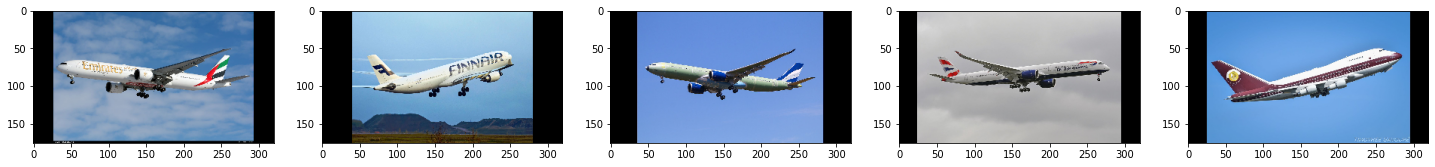

In [ ]:
n = 5 # кол-во случайных выводимых картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) # создаем полотно из n графиков
for i in range(n): # выводим в цикле n случайных изображений
  img = random.choice(images_airplane) # выбираем случайное фото для отображения
  axs[i].imshow(img) # отображаем фото
plt.show() # показываем изображения

In [ ]:
segments_airplane = [] # cоздаем пустой список для хранения оригинальных изображений

cur_time = time.time() # засекаем текущее время
for filename in sorted(os.listdir(directory + "Segment")): # проходим по всем файлам в каталоге по указанному пути
  segments_airplane.append(image.load_img(os.path.join(directory + "Segment", filename),
                                          target_size=(img_width, img_height))) # читаем очередную картинку и добавляем ее в список изображений с указанным target_size
print("Обучающая выборка загружена. Время загрузки: ", time.time() - cur_time, "c", sep="") # отображаем время загрузки картинок обучающей выборки



Обучающая выборка загружена. Время загрузки: 26.065958738327026c


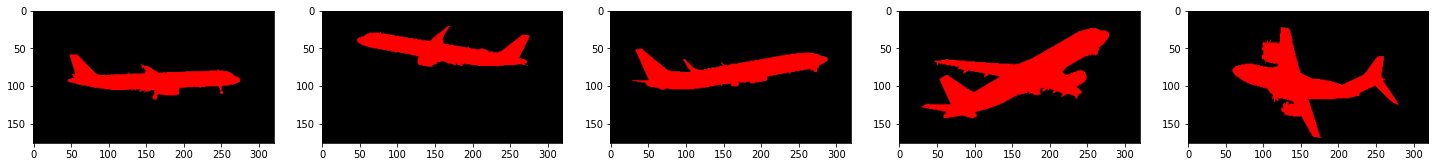

In [ ]:
n = 5 # кол-во случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25,5)) # создаем полотно из n графиков
for i in range(n): # выводим в цикле n случайных изображений
  img = random.choice(segments_airplane) # выбираем случайное фото для отображения
  axs[i].imshow(img) # отображаем фото
plt.show() # показываем изображения



# Cоздание выборки


In [ ]:
# Функция преобразования пикселя, сегментированного изображения в индекс (2 класса)
def color2index(color):
  index = 0
  if (color[0] + color[1] + color[2]) > 20: index = 1 # cамолет
  return index

In [ ]:
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0] # фон
  elif index == 1:
    color = [255, 0, 0] # самолет
  return color

In [ ]:
# Функция перевода индекса пикселя в to_categorical
def rgbToohe(y, num_classes):
  y_shape = y.shape  # запоминаем форму массива для решейпа
  y = y.reshape(y.shape[0] * y.shape[1], 3) # решейпим в двумерный массив
  yt = [] # создаем пустой лист
  for i in range(len(y)): # проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # преобразуем в numpy массив
  yt = yt.reshape(y_shape[0], y_shape[1], num_classes) # решейпим к исходному размеру
  return yt # возвращаем сформированный массив


In [ ]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # создаем пустой список под карты сегментации
  for seg in data: # пробегаемся по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) # переводим в numpy массив размерностью высота - ширина - кол-во каналов
    y = rgbToohe(y, num_classes) # получаем OHE представление сформированного массива
    yTrain.append(y) # добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # каждые 100 шагов
      print(len(yTrain)) # выводим количество обработанных изображений
  return np.array(yTrain) # возвращаем сформированный yTrain

In [ ]:
xTrain = []  # создаем пустой список под обучающую выборку
for img in images_airplane:
  x = image.img_to_array(img) # переводим изображение в numpy массив размерностью: высота - ширина - кол-во каналов
  xTrain.append(x) # добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # переводим в numpy
print(xTrain.shape) # размерность обусчющей выборки

(1000, 176, 320, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(segments_airplane, num_classes)
print("Время обработки: ", round(time.time() - cur_time, 2), "c")

100
200
300
400
500
600
700
800
900
1000
Время обработки:  570.92 c


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [ ]:
y_train.shape

(900, 176, 320, 2)

# Обучение модели

In [ ]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [ ]:
"""
Функция создания сети
  Входные параметры:
  - num_classes - количество классов
  - input_shape - размерность карты сегментации
"""

def unet(num_classes = 3, input_shape = (88, 120, 3)):
  img_input = Input(input_shape)

  # Block 1
  x = Conv2D(64, (3,3), padding="same", name="block1_conv1")(img_input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(64, (3,3), padding="same", name="block1_conv2")(x)
  x = BatchNormalization()(x)
  block1_out = Activation("relu")(x)

  x = MaxPooling2D()(block1_out)

  #Block 2
  x = Conv2D(128, (3,3), padding="same", name="block2_conv1")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(128, (3,3), padding="same", name="Block2_conv2")(x)
  x = BatchNormalization()(x)
  block2_out = Activation("relu")(x)

  x = MaxPooling2D()(block2_out)

  # Block 3
  x = Conv2D(256, (3,3), padding="same", name="block3_conv1")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(256, (3,3), padding="same", name="block3_conv2")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(256, (3,3), padding="same", name="block3_conv3")(x)
  x = BatchNormalization()(x)
  block3_out = Activation("relu")(x)

  x = MaxPooling2D()(block3_out)

  # Block 4
  x = Conv2D(512, (3,3), padding="same", name="block4_conv1")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(512, (3,3), padding="same", name="block4_conv2")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(512, (3,3), padding="same", name="block4_conv3")(x)
  x = BatchNormalization()(x)
  block4_out = Activation("relu")(x)
  x = block4_out

  # UP 2
  x = Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = concatenate([x, block3_out])
  x = Conv2D(256, (3,3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(256, (3,3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # UP 3
  x = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = concatenate([x, block2_out])
  x = Conv2D(128, (3,3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(128, (3,3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # UP 4
  x = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(64, (3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(64, (3,3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_classes, (3,3), activation="softmax", padding="same")(x)

  model = Model(img_input, x) # создаем модель с входом img_input и выходом x

  # Компилируем сеть
  model.compile(optimizer=Adam(),
                loss="categorical_crossentropy", 
                metrics=[dice_coef])
  
  return model

In [ ]:
modelAir = unet(2, (img_width, img_height,3))
history = modelAir.fit(x_train, y_train, epochs=35, batch_size=16, validation_data = (x_val, y_val))

Epoch 1/35
57/57 [==============================] - 54s 666ms/step - loss: 0.1145 - dice_coef: 0.9354 - val_loss: 24.4441 - val_dice_coef: 0.2830
Epoch 2/35
57/57 [==============================] - 36s 626ms/step - loss: 0.0566 - dice_coef: 0.9709 - val_loss: 0.1025 - val_dice_coef: 0.9556
Epoch 3/35
57/57 [==============================] - 36s 637ms/step - loss: 0.0608 - dice_coef: 0.9682 - val_loss: 0.2095 - val_dice_coef: 0.9422
Epoch 4/35
57/57 [==============================] - 37s 645ms/step - loss: 0.0498 - dice_coef: 0.9739 - val_loss: 0.1157 - val_dice_coef: 0.9685
Epoch 5/35
57/57 [==============================] - 37s 651ms/step - loss: 0.0477 - dice_coef: 0.9753 - val_loss: 0.0489 - val_dice_coef: 0.9783
Epoch 6/35
57/57 [==============================] - 37s 656ms/step - loss: 0.0424 - dice_coef: 0.9787 - val_loss: 0.0696 - val_dice_coef: 0.9711
Epoch 7/35
57/57 [==============================] - 38s 661ms/step - loss: 0.0456 - dice_coef: 0.9780 - val_loss: 0.0674 - val_di

In [ ]:
modelAir.save_weights("/content/drive/MyDrive/Базы/modelAir.h5")

# Распознавание

In [ ]:
modelAir = unet(2, (img_width, img_height, 3))
modelAir.load_weights("/content/drive/MyDrive/Базы/modelAir.h5")

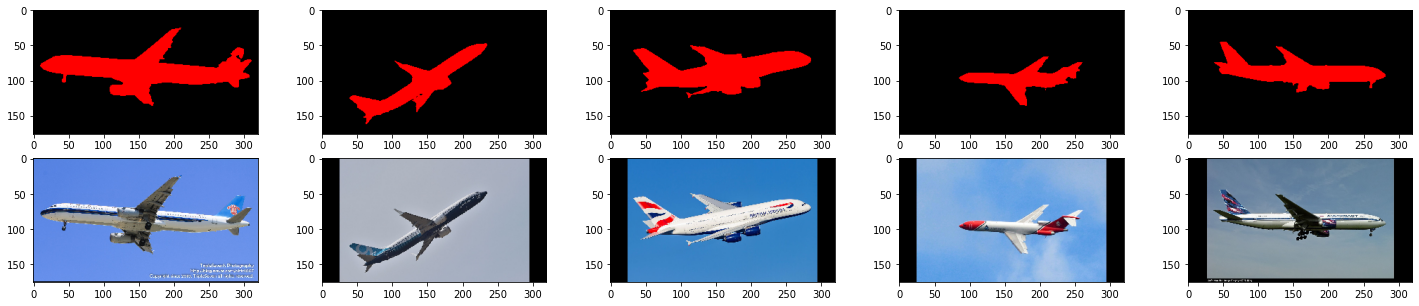

In [ ]:
count = 5
n_classes = 2
indexes = np.random.randint(0, len(x_val), count) # получаем count случайных индексов
fig, axs = plt.subplots(2, count, figsize=(25, 5)) # создаем полотно из count граф/
for i, idx in enumerate (indexes): # проходим по всем сгенерированным индексам
  predict = np.array(modelAir.predict(x_val[idx].reshape(1, img_width, img_height, 3))) # предиктим картинку
  pr = predict[0] # берем нулевой элемент из предикта
  pr1 = [] # пустой лист под сегментированную картинку из предикта
  pr = pr.reshape(-1, n_classes) # решейпим предикт
  for k in range(len(pr)): # проходим по всем уровням (кол-ва классов)
    pr1.append(index2color(pr[k])) # переводим индекс в пиксель
  pr1 = np.array(pr1) # преобразуем в numpy массив
  pr1 = pr1.reshape(img_width, img_height, 3) # решейпим к размеру изображения
  img = Image.fromarray(pr1.astype("uint8")) # получаем картинку из предикта
  axs[0,i].imshow(img.convert("RGBA")) # отображаем на графике в первой линии
  axs[1,i].imshow(Image.fromarray(x_val[idx].astype("uint8"))) # отображаем в графике на второй линии
